# MODULE 1: DATA CLEANING & PREPROCESSING

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## STEP 1: Define Dataset Path

In [8]:
data_dir = "PlantVillage"

## STEP 2: Parameters

In [9]:
img_height = 224
img_width = 224
batch_size = 32
seed = 42

## STEP 3: Load Dataset and Split into Train/Validation

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes found:", class_names)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.
Classes found: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## STEP 4: Visualize Sample Images

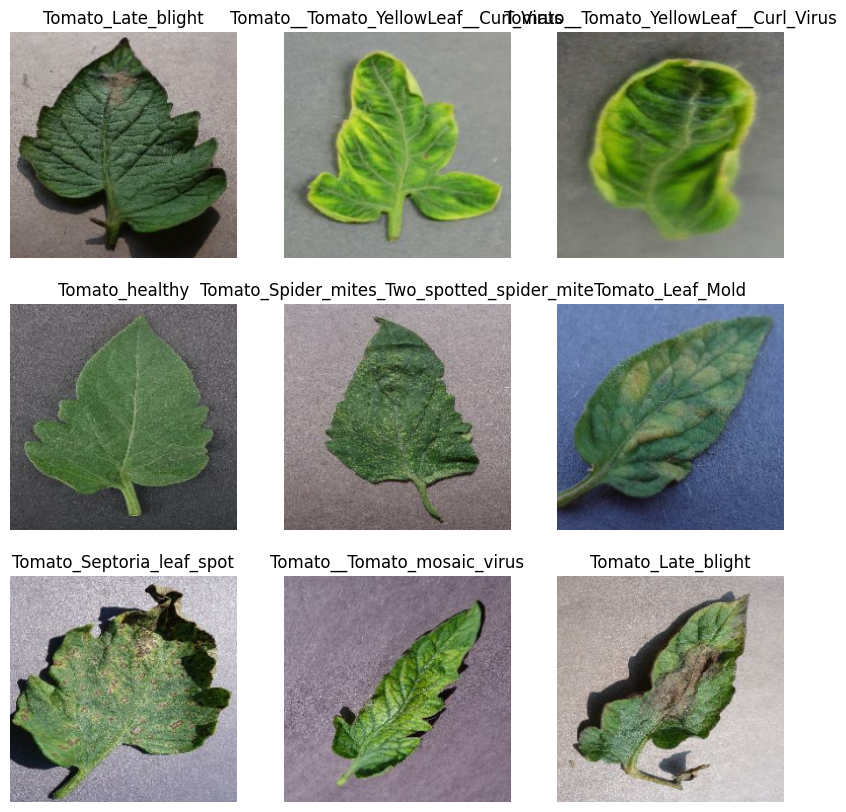

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## STEP 5: Optimize Dataset Pipeline

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset ready for model training.")

Dataset ready for model training.


## Data Augmentation

## STEP 6: Data Augmentation Layer

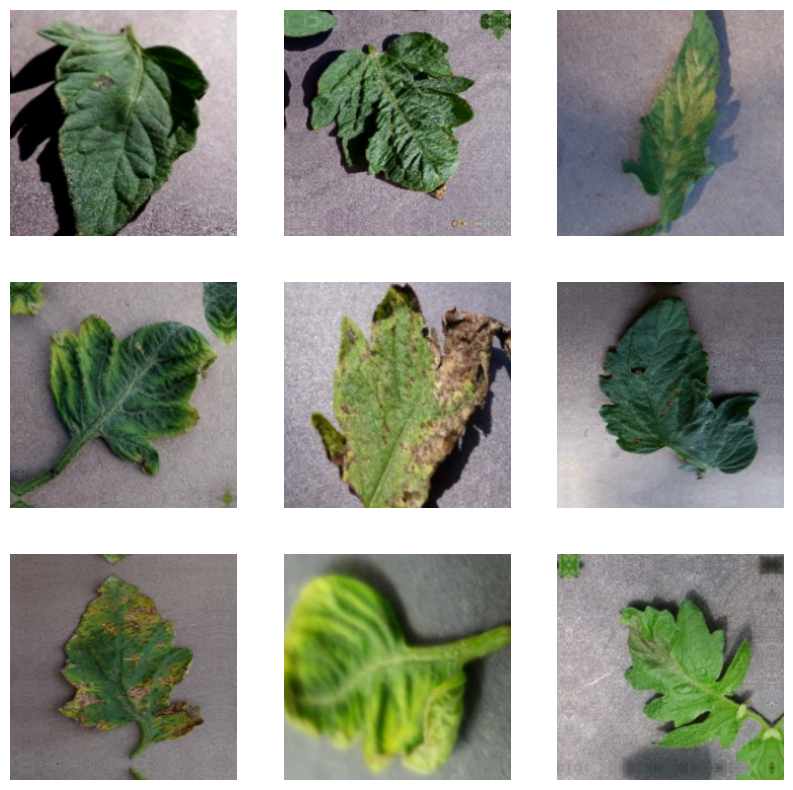

Data augmentation applied successfully.


In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Visualize some augmented images
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented = data_augmentation(images)[i]
        plt.imshow(augmented.numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
    break

print("Data augmentation applied successfully.")

# Module 2 — Model Building & Training (CNN)

## 2.1 - MODEL BUILDING (CNN)

In [18]:
from tensorflow.keras import models

num_classes = len(class_names)

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

C:\Users\jenia\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 86528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 - Compile Model

In [19]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 2.3 - Train Model

In [20]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 387s 953ms/step - accuracy: 0.5444 - loss: 1.3263 - val_accuracy: 0.7352 - val_loss: 0.8047
Epoch 2/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.7148 - loss: 0.8338 - val_accuracy: 0.6246 - val_loss: 1.1775
Epoch 3/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.7681 - loss: 0.6594 - val_accuracy: 0.7908 - val_loss: 0.6456
Epoch 4/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 353s 880ms/step - accuracy: 0.8146 - loss: 0.5352 - val_accuracy: 0.8235 - val_loss: 0.4767
Epoch 5/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 336s 839ms/step - accuracy: 0.8294 - loss: 0.4815 - val_accuracy: 0.8963 - val_loss: 0.2877
Epoch 6/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 337s 840ms/step - accuracy: 0.8510 - loss: 0.4281 - val_accuracy: 0.8101 - val_loss: 0.6567
Epoch 7/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 336s 838ms/step - accuracy: 0.8684 - loss: 0.3867 - val_accuracy: 0.8488 - val_loss: 0.4788
Epoch 8/20
401/401 ━━━━━━━━━━━━━━━━━━━━ 337s 840ms/step - accuracy: 0.8865 - loss:

## Visualizing Accuracy and Loss
## 2.4 - Plot Training Curves

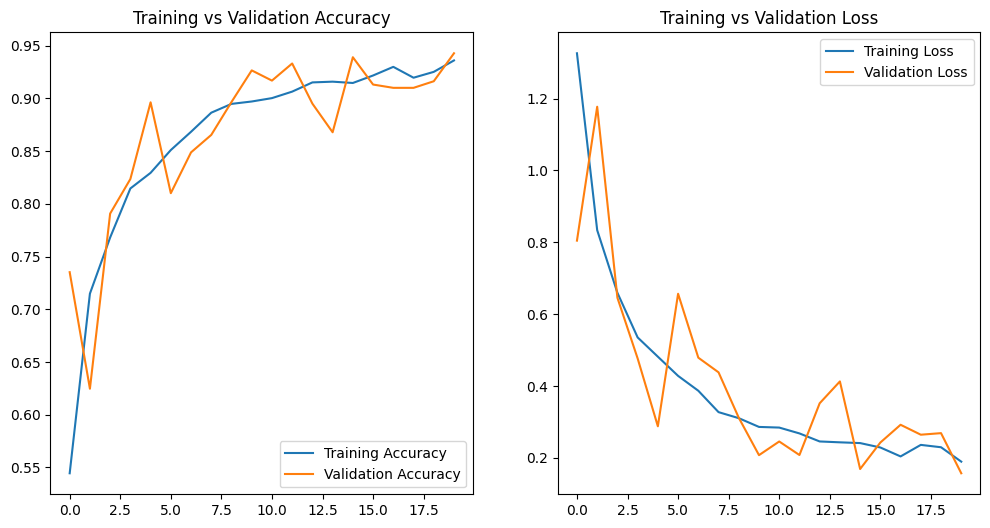

In [21]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

# Save the Trained Model

In [28]:
import os
# Define model export path
model_save_path = "tomato_disease_model"
os.makedirs(model_save_path, exist_ok=True)
model.export(model_save_path)
print(f"Model exported successfully to: {model_save_path}")

INFO:tensorflow:Assets written to: tomato_disease_model\assets


INFO:tensorflow:Assets written to: tomato_disease_model\assets


Saved artifact at 'tomato_disease_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2134323346704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134323344592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134323343056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134323344976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331220496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331221072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331224528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331221648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331224336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331224720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134331223376: TensorSpec(s

In [34]:
from keras.layers import TFSMLayer
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Loading exported SavedModel for inference (Keras 3 style)
tflayer = TFSMLayer("tomato_disease_model", call_endpoint="serving_default")

# Defining a wrapper model
loaded_model = tf.keras.Sequential([tflayer])

print("Model loaded successfully using TFSMLayer for inference!")

Model loaded successfully using TFSMLayer for inference!


## Test Prediction on a Single Image (after loading)

In [43]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Code\ML Projects\Tomato Disease Classification with Leaf Images


This image most likely belongs to 'Tomato_healthy' with a confidence of 23.19%.


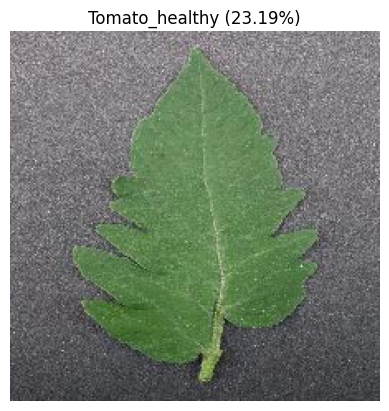

In [51]:
from keras.layers import TFSMLayer
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# Step 1: Set Image Path
# ==========================================================
test_image_path = "test_images/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG"

img_height, img_width = 224, 224

# ==========================================================
# Step 2: Load and Preprocess Image
# ==========================================================
img = image.load_img(test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

tflayer = TFSMLayer("tomato_disease_model", call_endpoint="serving_default")
loaded_model = tf.keras.Sequential([tflayer])

predictions = loaded_model(img_array)

# If the model returns a dict, extract the tensor
if isinstance(predictions, dict):
    predictions = list(predictions.values())[0]  # take first output tensor

score = tf.nn.softmax(predictions[0])
predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)

print(f"This image most likely belongs to '{predicted_class}' with a confidence of {confidence:.2f}%.")

plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()